In [1]:
using Pkg
Pkg.activate("/machome/gits/StatisticalProcesses")
Pkg.instantiate()

  Updating registry at `/opt/julia/share/site/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`


In [14]:
using Revise
using Plots
using Distributions
using StatisticalProcesses

In [15]:
using LinearAlgebra: norm

k(x, xp; σ, δ) = δ^2 * exp(-norm(x-xp)^2/(2σ^2))

k (generic function with 1 method)

StatisticalProcesses.loglikelihood(gp) = -459.28636714657557
variable_hypers = Symbol[:σn, :σ, :δ]
initial = [0.1, 0.5, 0.01]
lower = [0.001, 0.001, 0.001]
upper = [Inf, Inf, Inf]
Initial: Dict(:σn=>0.1,:σ=>0.5,:δ=>0.01)
res = Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [0.1,0.5,0.01]
 * Minimizer: [0.5238702703253266,0.9802718211742306, ...]
 * Minimum: 1.542143e+01
 * Iterations: 4
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 5.08e-09 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 1.56e-07 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 870
 * Gradient Calls: 870
Optimised: Dict(:σn=>0.52387,:σ=>0.980272,:δ=>0.609242)
loglikelihood(opt_gp) = -15.421430965017747
Marginal likelihood (Laplace approximation): -3.502779836850602
StatisticalProcesses.loglikelihood(stp) = -34.602

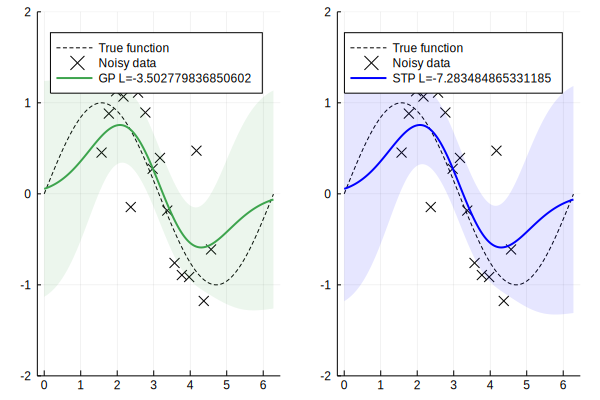

In [25]:
noise = :student
x = collect(π/2:0.2:3π/2)

if noise == :normal
    y = sin.(x) + 0.3*randn(length(x)) 
elseif noise == :student
# Add Student-T distributed noise
    t = TDist(5.)
    y = sin.(x) + 0.5*rand(t, length(x))
end

xx = collect(0:0.01:2π)
yy = sin.(xx)

p1 = plot(xx, yy, color=:black, linestyle=:dash, label="True function")
scatter!(x, y, color=:blue, marker=:x, label="Noisy data")

gp = GP(x, y, k; σn=0.1, σ=0.5, δ=0.01)
@show StatisticalProcesses.loglikelihood(gp)

hypers, L_gp, opt_gp = optimize_hypers(gp)
#@show hypers, L_gp

μ, v = predict(opt_gp, xx)
σ = sqrt.(v)

plot!(xx, μ, ribbon=(2σ, 2σ), lw=2, fillalpha=0.1, 
      label="GP L=$(L_gp[3])", ylims=(-2, 2))

stp = STP(x, y, k; ν=10.0, gp.hypers...)
@show StatisticalProcesses.loglikelihood(stp)

println()
hypers, L_stp, opt_stp = optimize_hypers(stp, fix=[:ν])
#@show hypers, L_stp

#stp_posterior = posterior(stp, xx)

p2 = plot(xx, yy, color=:black, linestyle=:dash, label="True function")
scatter!(x, y, color=:blue, marker=:x, label="Noisy data")

μ, v = predict(opt_stp, xx)
σ = sqrt.(v)

plot!(xx, μ, lw=2, color=:blue,
      ribbon=(2σ, 2σ), 
      fillalpha=0.1, fillcolor=:blue,
      label="STP L=$(L_stp[3])", ylims=(-2, 2))

plot(p1, p2)

In [293]:
h = ForwardDiff.hessian(L_stp[1], L_stp[2].minimizer)

3×3 Array{Float64,2}:
 352.346     9.11524  -20.3552 
   9.11524   4.2054    -3.47526
 -20.3552   -3.47526    7.61477

In [294]:
L_stp[2].minimizer

3-element Array{Float64,1}:
 0.19431812334222653
 1.6555600007104534 
 0.8921588074933795 

In [295]:
ForwardDiff.gradient(L_stp[1], L_stp[2].minimizer)

3-element Array{Float64,1}:
 7.454318051713926e-9 
 8.516278793280208e-10
 1.5664340935472865e-9

In [296]:
L_stp[1](L_stp[2].minimizer)

1.4351483019833928

In [297]:
det(h)

5942.2687302839995

In [298]:
LL = L_stp[1]
res = L_stp[2]
-LL(res.minimizer)*sqrt(((2π)^length(res.minimizer)) / det(h))

-0.29321787357836643